In [1]:
import scipy.io
import seaborn as sns
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('2hp_all_faults_1750.csv')

In [3]:
df = df[df['fault'] != '21_OR2']
df = df[df['fault'] != '21_OR3']
df = df[df['fault'] != '7_OR2']
df = df[df['fault'] != '7_OR3']

In [4]:
df['fault'].unique()

array(['21_BA', 'N', '21_IR', '21_OR1', '14_BA', '7_IR', '7_OR1', '14_IR',
       '7_BA', '14_OR1'], dtype=object)

In [5]:
np.random.normal(0, 1, df.shape[0])
signal_energy = np.mean(df['DE_data']**2)
print(signal_energy)
white_noise_1 = np.clip(np.random.normal(0, 1, df.shape[0]), -1.2, 1.1) # -4.5
signal_energy = np.mean(df['DE_data']**2)
noise_energy = np.mean(white_noise_1**2)
SNR =  10*np.log10(signal_energy/noise_energy)
print(SNR)

0.23307969559679226
-4.1538710575583035


In [6]:
df['DE_data'] = df['DE_data'] + white_noise_1

In [7]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

win_len=1200
stride=300

X=[]
Y=[]


for k in df['fault'].unique():
    
    df_temp_2 = df[df['fault']==k]
    
    for i in np.arange(0,len(df_temp_2)-(win_len),stride):
        temp = df_temp_2.iloc[i:i+win_len,:-1].values
        temp = temp.reshape((1,-1))
        X.append(temp)
        Y.append(df_temp_2.iloc[i+win_len,-1])
    
X=np.array(X)
print(X.shape)
X=X.reshape((X.shape[0],-1,1))
#X = np.repeat(X, 3, axis=3) # To repeat into 3 chanel format


Y=np.array(Y)
encoder= LabelEncoder()
encoder.fit(Y)
encoded_Y = encoder.transform(Y)
OHE_Y = to_categorical(encoded_Y)

(16205, 1, 1200)


In [8]:
X.shape

(16205, 1200, 1)

In [9]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,OHE_Y,test_size=0.2,shuffle=True)


In [10]:
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Input,Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D,Conv1D,MaxPooling1D
from tensorflow.keras.layers import LSTM
from keras.layers import BatchNormalization

# from tensorflow.keras.models import load_model
# cnn_model = load_model(r'H:\Gear Fault\Trained Model\CNN_model_gear.h5')



no_classes = len(df['fault'].unique())

cnn_model = Sequential()
cnn_model.add(Conv1D(filters=16, kernel_size=200, activation='relu', input_shape=(X.shape[1],X.shape[2])))
cnn_model.add(MaxPooling1D(pool_size=2))
cnn_model.add(BatchNormalization())
cnn_model.add(Conv1D(filters=32, kernel_size=100, activation='relu'))
cnn_model.add(MaxPooling1D(pool_size=2))
cnn_model.add(BatchNormalization())
cnn_model.add(Conv1D(filters=64, kernel_size=50, activation='relu'))
# cnn_model = Sequential()
# cnn_model.add(Conv1D(filters=64, kernel_size=100, activation='relu', input_shape=(X.shape[1],X.shape[2])))
# cnn_model.add(Conv1D(filters=32, kernel_size=50, activation='relu'))

# cnn_model.add(MaxPooling1D(pool_size=4))
# cnn_model.add(MaxPooling1D(pool_size=4))
cnn_model.add(Dropout(0.5))
cnn_model.add(LSTM(32))
# cnn_model.add(Flatten())
# cnn_model.add(Dense(40, activation='relu'))
cnn_model.add(Dense(no_classes, activation='softmax'))

cnn_model.summary()

cnn_model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 1001, 16)          3216      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 500, 16)          0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 500, 16)          64        
 ormalization)                                                   
                                                                 
 conv1d_1 (Conv1D)           (None, 401, 32)           51232     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 200, 32)          0         
 1D)                                                             
                                                        

In [11]:
batch_size =300
epochs = 70
history = cnn_model.fit(X_train, y_train, batch_size=batch_size,epochs=epochs,verbose=1,validation_split=0.1,shuffle=True)

Epoch 1/70


2022-03-01 00:07:08.166840: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


39/39 [==============================] - 22s 546ms/step - loss: 1.8311 - accuracy: 0.3188 - val_loss: 2.5592 - val_accuracy: 0.2274
Epoch 2/70
39/39 [==============================] - 22s 553ms/step - loss: 1.4258 - accuracy: 0.4670 - val_loss: 2.8313 - val_accuracy: 0.3138
Epoch 3/70
39/39 [==============================] - 24s 609ms/step - loss: 1.1910 - accuracy: 0.5496 - val_loss: 3.8140 - val_accuracy: 0.3261
Epoch 4/70
39/39 [==============================] - 24s 604ms/step - loss: 1.1168 - accuracy: 0.5708 - val_loss: 4.1070 - val_accuracy: 0.3246
Epoch 5/70
39/39 [==============================] - 23s 603ms/step - loss: 1.0273 - accuracy: 0.6110 - val_loss: 4.5977 - val_accuracy: 0.3454
Epoch 6/70
39/39 [==============================] - 24s 621ms/step - loss: 0.9770 - accuracy: 0.6243 - val_loss: 4.6076 - val_accuracy: 0.3470
Epoch 7/70
39/39 [==============================] - 25s 630ms/step - loss: 0.9116 - accuracy: 0.6541 - val_loss: 4.0837 - val_accuracy: 0.3601
Epoch 8/70

Test loss: 0.6144278049468994
Test accuracy: 0.8485035300254822


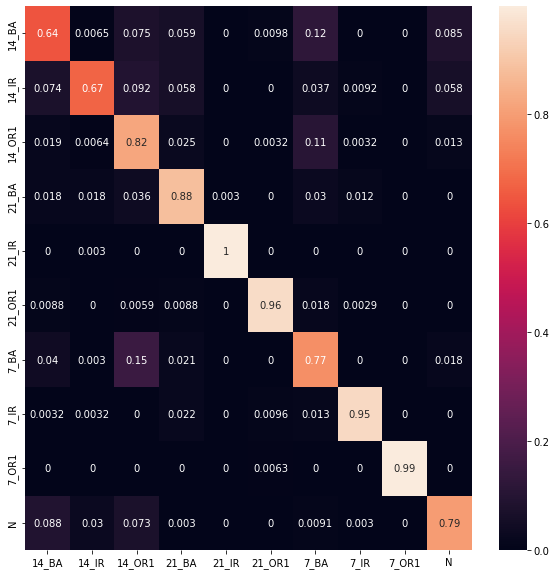

In [15]:
def inv_Transform_result(y_pred):    
    y_pred = y_pred.argmax(axis=1)
    y_pred = encoder.inverse_transform(y_pred)
    return y_pred



y_pred=cnn_model.predict(X_test)

score = cnn_model.evaluate(X_test, y_test, verbose = 0) 

print('Test loss:', score[0]) 
print('Test accuracy:', score[1])

Y_pred=inv_Transform_result(y_pred)
Y_test = inv_Transform_result(y_test)




from sklearn.metrics import confusion_matrix


plt.figure(figsize=(10,10))
cm = confusion_matrix(Y_test, Y_pred,normalize='true')
f = sns.heatmap(cm, annot=True,xticklabels=encoder.classes_,yticklabels=encoder.classes_)
plt.show()

In [16]:
dummy_cnn = Model(inputs=cnn_model.input,outputs=cnn_model.layers[8].output)
y_viz = dummy_cnn.predict(X_train)

/Users/divyanshuchaudhari/miniforge3/envs/pytorch_m1/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 12964 samples in 0.001s...
[t-SNE] Computed neighbors for 12964 samples in 2.876s...
[t-SNE] Computed conditional probabilities for sample 1000 / 12964
[t-SNE] Computed conditional probabilities for sample 2000 / 12964
[t-SNE] Computed conditional probabilities for sample 3000 / 12964
[t-SNE] Computed conditional probabilities for sample 4000 / 12964
[t-SNE] Computed conditional probabilities for sample 5000 / 12964
[t-SNE] Computed conditional probabilities for sample 6000 / 12964
[t-SNE] Computed conditional probabilities for sample 7000 / 12964
[t-SNE] Computed conditional probabilities for sample 8000 / 12964
[t-SNE] Computed conditional probabilities for sample 9000 / 12964
[t-SNE] Computed conditional probabilities for sample 10000 / 12964
[t-SNE] Computed conditional probabilities for sample 11000 / 12964
[t-SNE] Computed conditional probabilities for sample 12000 / 12964
[t-SNE] Computed conditional probabilities for sa

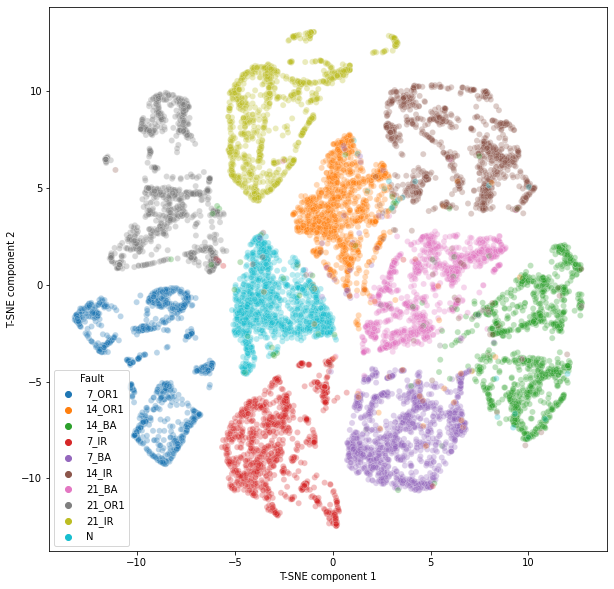

In [17]:
from sklearn.manifold import TSNE

X_t_sne = TSNE(n_components=2, learning_rate='auto',verbose=1, perplexity=40, n_iter=300).fit_transform(y_viz)

tSNEdf = pd.DataFrame(data = X_t_sne, columns = ['T-SNE component 1', 'T-SNE component 2'])

tSNEdf['Fault']=inv_Transform_result(y_train)


# Plot the PC-1 and PC-2
fig, ax = plt.subplots(figsize=(10,10))
sns.scatterplot(x=tSNEdf['T-SNE component 1'],y=tSNEdf['T-SNE component 2'],hue='Fault',
    data=tSNEdf,
    legend="full",
    alpha=0.3)
plt.show()